# Setup

## Imports and Configuration

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import json
from datetime import datetime
import functools
import matplotlib.pyplot as plt
import seaborn as sb
from anndata import AnnData
import scanpy as sc
import pandas as pd
import numpy as np
import corescpy as cr

pd.options.display.max_columns = 100
pd.options.display.max_rows = 200
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

palette = "tab20"


def construct_file(sample, slide, date=None, timestamp=None,
                   panel_id="TUQ97N", prefix="output-XETG00189",
                   project_owner="EA", run="CHO-001", directory=None):
    """Construct file path from information."""
    if isinstance(sample, str):
        sample = [sample]
    if "outputs" not in directory and os.path.exists(
            os.path.join(directory, "outputs")):
        directory = os.path.join(directory, "outputs")
    print(directory)
    panel_id, prefix, project_owner, slide, date, timestamp = [
        [x] * len(sample) if isinstance(x, str) else list(x) if x else x
        for x in [panel_id, prefix, project_owner, slide, date, timestamp]]
    run = [run] * len(sample) if isinstance(run, (str, int, float)) else run
    block = ["-".join(i) for i in zip(sample, panel_id, project_owner)]
    fff = [f"{prefix[i]}__{slide[i]}__{block[i]}" for i in range(len(sample))]
    if date is None or timestamp is None:
        for i, x in enumerate(fff):  # iterate current file stems
            ddd = os.path.join(directory, panel_id[i], run[i])
            print(ddd)
            matches = sum([x in d for d in os.listdir(ddd)])
            if  matches != 1:
                raise ValueError(f"{x} found in 0 or multiple file paths",
                                 f"\n\n{os.listdir(ddd)}")
            fff[i] = os.path.join(ddd, np.array(os.listdir(ddd))[np.where([
                x in d for d in os.listdir(ddd)])[0][0]])  # find match
    else:
        fff = [os.path.join(directory, panel_id[i], run[i],
                            f"{x}__{date[i]}__{timestamp[i]}")
               for i, x in enumerate(fff)]
    return fff

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

## Options

In [2]:
# Column Names
col_sample_id_original = "Sample ID"
col_sample_id = "Sample"
col_subject = "Patient"
col_batch = "Slide"
col_path = "file_path"
# col_date_time, col_date = "Date Sectioned", "Date"
col_date_time, col_date = None, None
col_inflamed, col_stricture = "Inflamed", "Stricture"
col_condition = "Condition"
meta_rn = {"Name": col_subject, "Slide ID": col_batch,
           "Inflammation Status": col_inflamed}

# Directories & Metadata
# Replace manually or mirror my file/directory tree in your home
include_stricture = True
run = "CHO-001"
samples = ["50452A", "50452B", "50452C"]
# samples = ["50452A", "50452B"]
# samples = ["50452A", "50452B", "50452C", "50564A4", "50618B5"]
# run = ["CHO-001"] * 3 + ["CHO-002"] * 3
panel_id = "TUQ97N"
prefix = "output-XETG00189"
project_owner = "EA"
ddu = os.path.expanduser("~")
ddl = "/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library"
ddd = os.path.join(ddl, "outputs", panel_id)
panel = os.path.join(ddu, "projects/senescence/ProposedGenePanel.xlsx")
file_ann = os.path.join(ddu, "corescpy/examples/annotation_guide.xlsx")

# Input/Output Options
reload = True
out_dir = os.path.join(ddd, "nebraska")  # set to None to avoid saving
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Computing Resources
gpu = False
sc.settings.n_jobs = 4
sc.settings.max_memory = 150

# Read Metadata & Other Information
annot_df = pd.read_excel(file_ann)
metadata = pd.read_excel(os.path.join(ddl, "Xenium_Samples_02092024.xlsx"),
                         dtype={"Slide ID": str})
metadata = metadata.rename(meta_rn, axis=1)
if samples not in ["all", None]:  # subset by sample ID?
    metadata = metadata.set_index(col_sample_id_original).loc[
        samples].reset_index()

# Processing & Clustering Options
resolution = 0.5
min_dist = 1
n_comps = 20
# col_qscore = ?
# custom_thresholds = {col_qscore: [, None]}
custom_thresholds = None
genes_subset = list(annot_df.iloc[:, 0])
kws_pp = dict(cell_filter_pmt=None, cell_filter_ncounts=[50, None],
              cell_filter_ngene=[30, None], gene_filter_ncell=[3, None],
              gene_filter_ncounts=[3, None],
              custom_thresholds=custom_thresholds,
              kws_scale=dict(max_value=10, zero_center=True))
kws_umap = dict(min_dist=min_dist, method="rapids") if gpu is True else dict(
    min_dist=min_dist)
kws_cluster = dict(use_gpu=gpu, kws_umap=kws_umap, kws_neighbors=None,
                   use_highly_variable=False, n_comps=n_comps,
                   genes_subset=genes_subset, resolution=resolution)
# kws_subcluster = dict(use_gpu=gpu, kws_umap=dict(min_dist=0.3),
#                       kws_neighbors=None, use_highly_variable=False,
#                       n_comps=n_comps, genes_subset=genes_subset,
#                       method_cluster="leiden", resolution=0.5)
kws_subcluster = dict(method_cluster="leiden", resolution=0.5)

# Revise Metadata & Construct Variables from Options
if col_stricture not in metadata.columns:
    metadata.loc[:, col_stricture] = metadata["Sample Location"].apply(
        lambda x: "Stricture" if "stricture" in x.lower() else "None")
metadata.loc[:, col_condition] = metadata.apply(
    lambda x: "Stricture" if "stricture" in x[col_stricture].lower() else x[
        col_inflamed].capitalize() , axis=1)
if col_date_time:
    metadata.loc[:, col_date] = metadata[col_date_time].apply(
        lambda x: datetime.strftime(x, "%Y%m%d"))
    dates = list(metadata[col_date])
else:
    dates = None
metadata.loc[:, col_sample_id] = metadata.apply(
    lambda x: f"{x[col_condition]}-{x[col_sample_id_original]}" , axis=1)
metadata = metadata.set_index(col_sample_id)
metadata.loc[:, col_path] = construct_file(
    list(metadata[col_sample_id_original]), list(metadata[col_batch]),
    dates, panel_id=panel_id, prefix=prefix,
    project_owner=project_owner, run=run, directory=ddl)
col_cell_type = "Annotation"
file_path_dict = dict(zip(metadata.index.values, metadata["file_path"]))
kws_init = dict(col_batch=col_batch, col_subject=col_subject,
                col_sample_id=col_sample_id, col_cell_type=col_cell_type)

# Annotation File
col_assignment = "Bin"
assign = pd.read_excel(file_ann, index_col=0).dropna(subset=col_assignment)
sources = assign[col_assignment].unique()
rename = dict(zip(sources, [" ".join([i.capitalize() if i and i[
    0] != "(" and not i.isupper() and i not in [
        "IgG", "IgA"] else i for i in x.split(" ")]) if len(x.split(
            " ")) > 1 else x for x in [re.sub("glia", "Glia", re.sub(
                "_", " ", j)) for j in sources]]))
assign.loc[:, col_assignment] = assign[col_assignment].replace(rename)
assign = assign.rename_axis("Gene")
marker_genes_dict = dict(assign.reset_index().groupby(col_assignment).apply(
    lambda x: list(pd.unique(x.Gene))))  # to marker dictionary

# Subset if Desired
if include_stricture is False:
    metadata = metadata[metadata.Stricture != "Stricture"]
metadata

# Genes
# genes = ["CDKN1A", "CDKN2A", "TP53", "PLAUR", "PTGER4", "FTL", "IL6ST"]
# cell_types = ["ILC3", "LTi-like NCR+ ILC3", "LTi-like NCR- ILC3",
#               "ILCP", "Macrophages", "Stem cells"]
# palette = ["r", "tab:pink", "m", "b", "tab:brown", "cyan"]
# High in inf. vs. un
# OSM
# IL13
# IL1B
# IL6
# TNF
# S100A8
# S100A9
# ------------------------------
# High in stricture vs inf/un
# PDGFRA
# IL6ST
# PTPN1
# IFNG

/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/CHO-001


Sample ID  Patient     Status          Project  \
Sample                                                             
Uninflamed-50452A    50452A    50452  Available  scRNA & Spatial   

                  Sample Location    Inflamed    Slide  GRID ID  \
Sample                                                            
Uninflamed-50452A  Terminal Ileum  uninflamed  0010700  1011335   

                  Procedure Date  Age     Sex   Race Hispanic  \
Sample                                                          
Uninflamed-50452A     2023-12-04   69  female  white       NO   

                         Diagnosis            Project.1  Procedure  \
Sample                                                               
Uninflamed-50452A  Crohn's Disease  Helmsley-Senescence  Resection   

                  Disease Status  Date Collected      Date Sectioned  \
Sample                                                                 
Uninflamed-50452A         Active             NaN 2024-01-22 15:25:38   

                  Date of Hybridization Storage in 4C     Created By  \
Sample                                                                 
Uninflamed-50452A   2024-01-23 15:25:58           YES  ksenija sabic   

                                  Created  Storage Status  Sample Location.1  \
Sample                                                                         
Uninflamed-50452A 2024-02-06 15:26:47.887  Not in storage                NaN   

                   Storage Row  Storage Col  Checked Out By Stricture  \
Sample                                                                  
Uninflamed-50452A          NaN          NaN             NaN      None   

                    Condition  \
Sample                          
Uninflamed-50452A  Uninflamed   

                                                           file_path  
Sample                                                                
Uninflamed-50452A  /mnt/cho_lab/disk2/elizabeth/data/shared-xeniu...

# Data

## Loading

In [3]:
%%time

# Load Spatial Data
suff = str(f"res{re.sub('[.]', 'pt', str(resolution))}_dist"
           f"{re.sub('[.]', 'pt', str(min_dist))}_npc{n_comps}")  # file end
selves, paths_he, file_mks, out_files = [], [], [], []
for x in metadata.index.values:
    self = cr.Spatial(metadata.loc[x][col_path], library_id=x, **kws_init)
    for i in metadata:  # add metadata for subject
        self.rna.obs.loc[:, i] = str(metadata.loc[x][i])  # add metadata
    selves += [self]
    paths_he += [os.path.join(metadata.loc[x][
        col_path], "aux_outputs/image_he.ome.tif")]  # H&E paths
        # out_files += [os.path.join(out_dir, f"{x}.zarr")]
    if out_dir is not None:
        out_files += [os.path.join(out_dir, f"{x}__{suff}.zarr")]
    file_mks += [os.path.join(out_dir, f"{x}__{suff}_markers.csv")]

# Reload Processed & Clustered Data (Optionally)
if reload is True:
    for i, s in enumerate(selves):
        mks = file_mks[i] if os.path.exists(file_mks[i]) else None
        s.update_from_h5ad(file=out_files[i], file_path_markers=mks)
        print(s.adata)



<<< INITIALIZING SPATIAL CLASS OBJECT >>>



<<< INITIALIZING OMICS CLASS OBJECT >>>

Unused keyword arguments: {'library_id': 'Uninflamed-50452A', 'visium': False}.




col_gene_symbols="gene_symbols"
col_cell_type="Annotation"
col_sample_id="Sample"
col_batch="Slide"
col_subject="Patient"
col_condition=None
col_num_umis=None



key_control=None
key_treatment=None
INFO     reading                                                                                                   
         /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/CHO-001/output-XETG00189__0010700__
         50452A-TUQ97N-EA__20240126__205019/cell_feature_matrix.h5                                                 


dsfasfda AnnData object with n_obs × n_vars = 333825 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'


Cell Counts: Initial


Observations: 333825



Gene Counts: Initial

Empty DataFrame
Columns: [index, gene_ids, feature_types, genome]
Index: []





 SpatialData object with:
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 57808, 45580), (1, 28904, 22790), (1, 14452, 11395), (1, 7226, 5697), (1, 3613, 2848)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 57808, 45580), (1, 28904, 22790), (1, 14452, 11395), (1, 7226, 5697), (1, 3613, 2848)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     ├── 'cell_boundar

## Plot

In [ ]:
if reload is True:
    for i, s in enumerate(selves):
        s.plot_spatial(color="leiden")
        # s.plot_spatial(color=col_cell_type)

# Annotation & Sub-Clustering

In [ ]:
for s in selves:
    _ = s.cluster(**kws_cluster)
    _ = s.annotate_clusters(file_ann, col_cell_type="leiden",
                            col_annotation=col_cell_type,
                            col_assignment=col_assignment)  # annotate & write
    s.plot_spatial(color=col_cell_type)

In [ ]:
# cat_epi = ["BEST2+ Goblet Cell", "BEST4+ Epithelial", "EC Cells (NPW+)",
#            "EC Cells (TAC1+)", "Enterocyte", "Epithelial", "Goblet Cell",
#            "I Cells (CCK+)", "Paneth", "D Cells (SST+)",
#            "Stem Cells", "N Cells (NTS+)", "K Cells (GIP+)",
#            # "Colonocyte",
#            "L Cells (PYY+)", "Tuft", "Microfold Cell"]
# cat_epi = list(np.array()[np.where(["epithelial" in x.lower()
#                                     for x in marker_genes_dict])[0]])
# file_ann_epi = pd.concat([pd.Series(marker_genes_dict[x]) for x in cat_epi],
#                          keys=cat_epi, names=["Type"]).to_frame(
#                              "Gene").reset_index(0).set_index("Gene")
file_ann_epi = file_ann
# key_cell_type, col_ann = ["7"], "Subclustering_Epi"
key_cell_type, col_ann = None, "leiden_sub"
for s in selves:
    ann = s.subcluster(restrict_to=(col_cell_type, key_cell_type), copy=False,
                       key_added="leiden_sub", **kws_subcluster)
    s.annotate_clusters(kws_annotation={"model": file_ann_epi,
                                        "col_assignment": "Bin"},
                        col_annotation=[col_ann, col_cell_type])
    s.plot_spatial(color=col_ann)

In [ ]:
for s in selves:
    s.write(out_files[i])

# Workspace

In [5]:
adata_sp = selves[0].adata.table.copy()
# adata_sc = sc.read(os.path.join("/mnt/cho_lab/disk2/elizabeth/data",
#                                 "2023-05-12_CombinedCD-v2_new.h5ad"))
# adata_sc = adata_sc[adata_sc.obs.Region == "Ileum"]
# sdata_new, sdata, adata_sc, ad_map, df_compare = cr.pp.integrate_spatial(
#     sdata, adata_sc, col_cell_type="ClusterAnnotation")
# adata_sc = sc.read("/mnt/cho_lab/disk2/elizabeth/data/elmentaite.h5ad",
#                    col_gene_symbols="feature_name")
# adata_sc = adata_sc[adata_sc.obs.tissue == "small intestine"]
# adata_sc.var = adata_sc.var.reset_index().set_index("feature_name")
out = cr.pp.integrate_spatial(
    adata_sp, adata_sc, col_cell_type="cell_type",
    # mode="cells",
    mode="clusters",
    key_added="rank_genes_groups_cell_type", markers=200,
    col_annotation="Integrated_Spatial")
adata_sp_new, sdata, adata_sc_n, ad_map, df_compare, fig = out

200 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
465 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
Allocate tensors for mapping.
Begin training with 200 genes and uniform density_prior in clusters mode...
Printing scores every 100 epochs.


Score: 0.348, KL reg: 0.055
Score: 0.580, KL reg: 0.003
Score: 0.587, KL reg: 0.003
Score: 0.589, KL reg: 0.003
Score: 0.590, KL reg: 0.003
Score: 0.590, KL reg: 0.003
Score: 0.591, KL reg: 0.003
Score: 0.591, KL reg: 0.003
Score: 0.591, KL reg: 0.003
Score: 0.591, KL reg: 0.003


Saving results..


KeyError: 'Integrated_Spatial'

In [42]:
adata_sp_new = tg.project_genes(adata_map=ad_map, adata_sc=adata_sc)

ValueError: The two AnnDatas need to have same `obs` index.

In [41]:
sdata.obsm["tangram_ct_pred"]

stromal cell  mesodermal cell  enterocyte of colon  \
0       3.133152e-09     8.230007e-09         1.029421e-08   
1       5.299712e-06     6.225337e-06         2.497223e-06   
2       1.159862e-05     2.261884e-08         6.620805e-09   
3       9.542347e-06     3.287576e-08         7.404245e-07   
4       6.165138e-08     4.729897e-06         2.432080e-06   
...              ...              ...                  ...   
333819  2.542496e-06     5.424163e-07         1.682117e-05   
333820  2.667846e-06     8.134738e-06         1.712826e-06   
333821  2.208039e-06     7.698821e-06         1.808450e-06   
333823  5.659383e-06     4.839426e-06         3.862508e-07   
333824  2.180731e-06     4.730149e-07         1.669448e-08   

        enteric smooth muscle cell  progenitor cell    glial cell  \
0                     6.590864e-09     4.761040e-09  1.427182e-08   
1                     6.108780e-08     8.094502e-08  8.907094e-06   
2                     9.591718e-09     1.061664e-08  1.831853e-08   
3                     1.541336e-08     4.598728e-08  8.997722e-06   
4                     4.710272e-06     3.920314e-08  1.673815e-05   
...                            ...              ...           ...   
333819                1.875589e-07     1.999275e-08  4.345737e-08   
333820                7.537561e-06     1.996596e-06  1.008738e-07   
333821                7.355962e-08     2.167082e-05  4.618821e-06   
333823                4.722159e-07     1.758638e-05  3.498117e-07   
333824                6.805800e-08     5.776041e-08  7.521041e-07   

        transit amplifying cell     stem cell      pericyte  naive B cell  \
0                  3.406863e-09  4.845680e-09  1.292358e-08  1.115043e-08   
1                  4.561994e-08  6.049518e-08  2.422083e-07  2.670541e-06   
2                  5.967359e-09  1.229312e-08  2.113580e-08  6.123350e-06   
3                  7.912669e-09  2.143199e-08  9.567120e-06  1.063277e-07   
4                  2.830983e-08  7.505179e-09  7.343657e-08  1.488492e-07   
...                         ...           ...           ...           ...   
333819             1.340141e-08  7.871994e-06  2.214107e-07  8.168815e-08   
333820             1.202888e-08  1.395487e-08  4.688841e-07  6.568558e-07   
333821             1.579670e-08  3.102742e-08  1.085108e-07  9.571434e-08   
333823             1.911621e-08  3.937654e-08  1.982329e-06  6.980923e-06   
333824             5.859679e-09  2.440415e-08  8.678195e-08  1.433215e-07   

        myofibroblast cell  intestine goblet cell  capillary endothelial cell  \
0             4.625797e-09           1.086393e-08                7.533714e-09   
1             4.327257e-08           5.143535e-08                1.362696e-05   
2             8.381734e-09           3.832476e-08                5.473676e-05   
3             2.870959e-05           3.758847e-08                1.990313e-08   
4             2.730677e-08           3.859136e-08                2.322575e-08   
...                    ...                    ...                         ...   
333819        3.435454e-06           1.619343e-05                2.863260e-07   
333820        4.498825e-08           9.007900e-08                2.277816e-08   
333821        2.998384e-08           5.965262e-06                1.589232e-08   
333823        3.466776e-07           6.690247e-08                1.080258e-07   
333824        1.466759e-08           4.717241e-08                1.232882e-08   

        activated CD8-positive, alpha-beta T cell  IgA plasma cell  \
0                                    1.877839e-05     3.855227e-09   
1                                    7.128661e-06     1.915121e-06   
2                                    1.788047e-08     1.022342e-08   
3                                    4.467269e-08     1.140765e-08   
4                                    3.695110e-08     4.374738e-08   
...                                           ...              ...   
333819                               7.050180e

In [52]:
sdata

AnnData object with n_obs × n_vars = 312393 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_filter_pmt', 'cell_filter_ncounts', 'ce

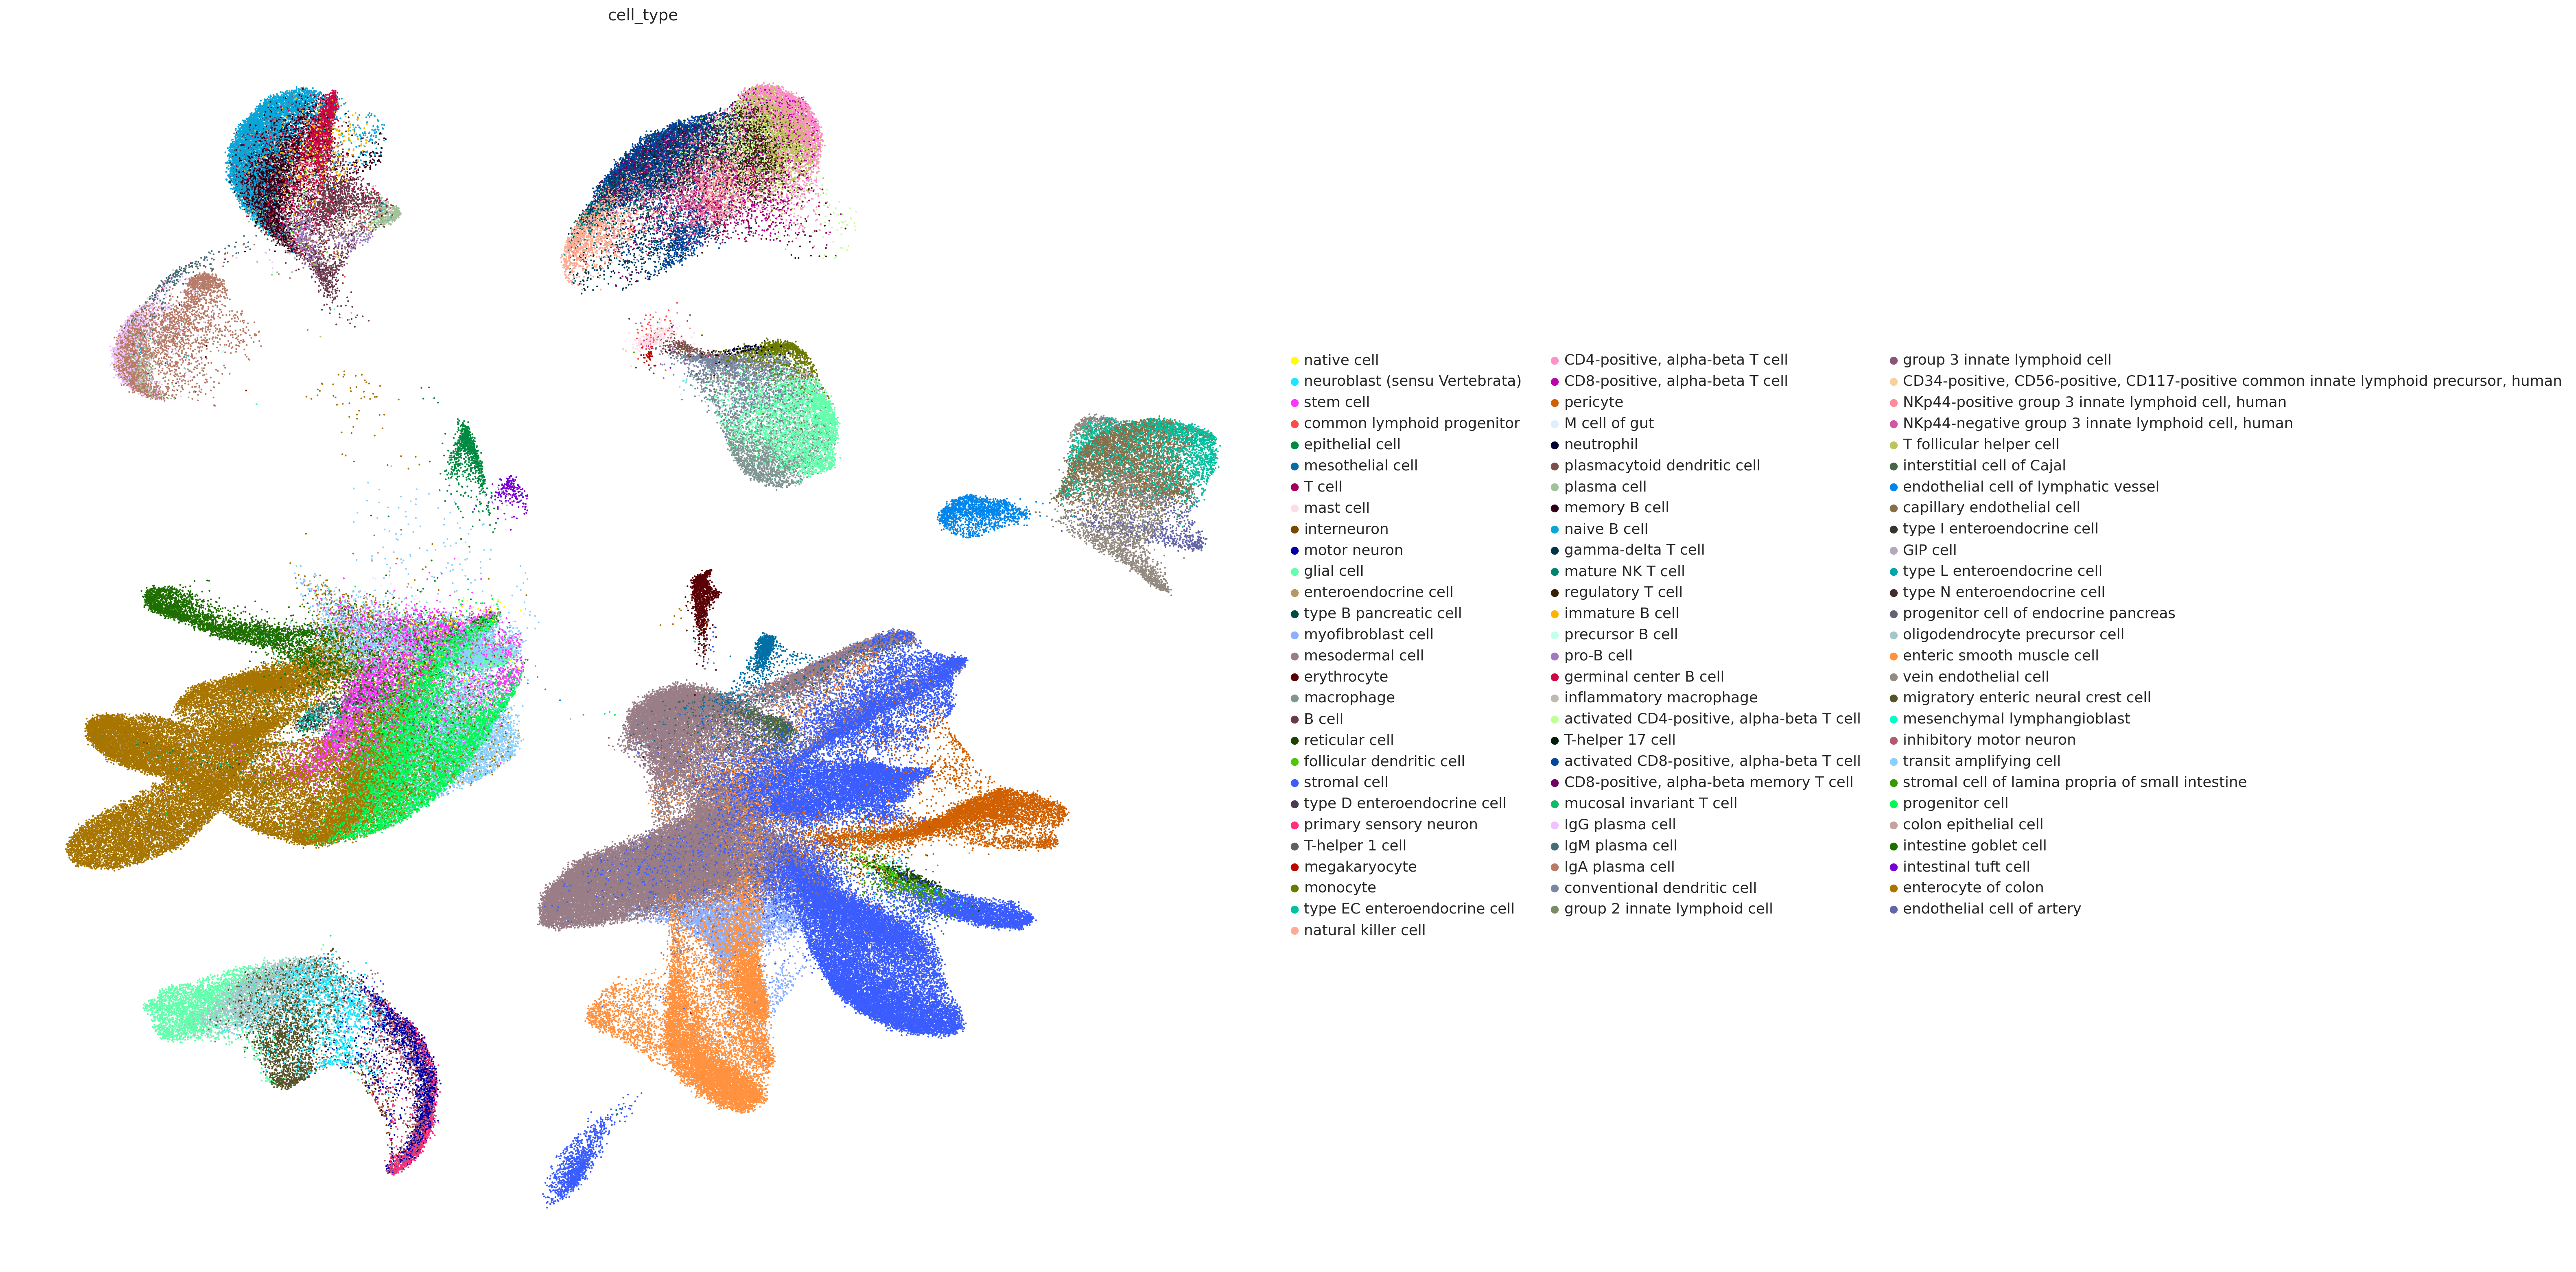

AnnData object with n_obs × n_vars = 312393 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_filter_pmt', 'cell_filter_ncounts', 'ce

{'clusters': <Figure size 2000x2000 with 0 Axes>,
 'spatial': 'Traceback (most recent call last):\n  File "/home/elizabeth/elizabeth/corescpy/corescpy/visualization/spatial_plots.py", line 68, in plot_spatial\n    col_segment) else sq.pl.spatial_scatter(ann, **kws)\n  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/squidpy/pl/_spatial.py", line 419, in spatial_scatter\n    return _spatial_plot(adata, shape=shape, seg=None, seg_key=None, **kwargs)\n  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/squidpy/pl/_spatial.py", line 169, in _spatial_plot\n    color_params = _prepare_args_plot(\n  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py", line 747, in _prepare_args_plot\n    if c is not None and c in adata.obs and isinstance(adata.obs[c].dtype, CategoricalDtype):\n  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/pa

<Figure size 2000x2000 with 0 Axes>

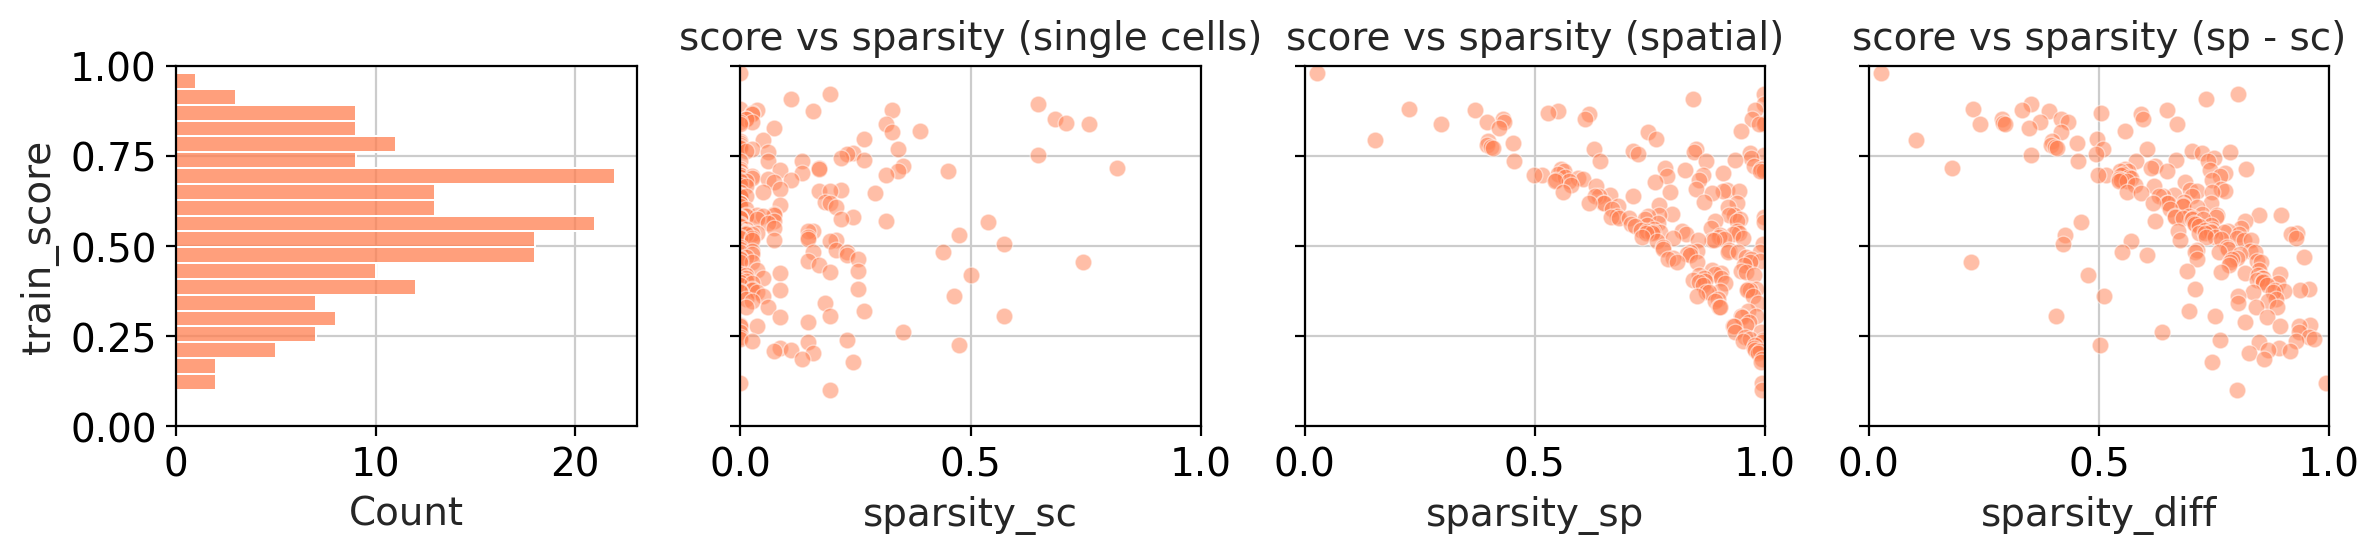

In [60]:
figs = cr.pl.plot_integration_spatial(sdata, adata_sp_new=None, adata_sc=adata_sc,
                             col_cell_type=col_cell_type, ad_map=ad_map, cmap="magma",
                             df_compare=df_compare, plot_genes=None, perc=0.01)
figs

In [53]:

    cmap = "magma"
    perc = 0.01

    def construct_obs_plot(dfp, adata, perc=0, suffix=None):
        """Helper function from Tangram."""
        dfp = dfp.clip(dfp.quantile(perc), dfp.quantile(1 - perc), axis=1)  # clip
        dfp = (dfp - dfp.min()) / (dfp.max() - dfp.min())  # normalize
        if suffix:
            dfp = dfp.add_suffix(" ({})".format(suffix))
        adata.obs = pd.concat([adata.obs, dfp], axis=1)

    # construct df_plot
    annotation_list = list(pd.unique(adata_sc.obs[col_cell_type]))
    dff = sdata.obsm["tangram_ct_pred"][annotation_list]
    construct_obs_plot(dff, sdata, perc=perc)
    cr.pl.plot_spatial(
        sdata, color=annotation_list, cmap=cmap)

AnnData object with n_obs × n_vars = 312393 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_filter_pmt', 'cell_filter_ncounts', 'ce

'Traceback (most recent call last):\n  File "/home/elizabeth/elizabeth/corescpy/corescpy/visualization/spatial_plots.py", line 68, in plot_spatial\n    col_segment) else sq.pl.spatial_scatter(ann, **kws)\n  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/squidpy/pl/_spatial.py", line 419, in spatial_scatter\n    return _spatial_plot(adata, shape=shape, seg=None, seg_key=None, **kwargs)\n  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/squidpy/pl/_spatial.py", line 169, in _spatial_plot\n    color_params = _prepare_args_plot(\n  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py", line 747, in _prepare_args_plot\n    if c is not None and c in adata.obs and isinstance(adata.obs[c].dtype, CategoricalDtype):\n  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/pandas/core/generic.py", line 6293, in __getattr__\n    return o

In [46]:
sdata.uns["spatial"].keys()


dict_keys(['Uninflamed-50452A'])

In [ ]:
import tangram as tg

sdata.uns["spatial"][s._library_id]["images"]["hires"] = sdata.uns[
    "spatial"][s._library_id]["images"][list(sdata.uns["spatial"][
        s._library_id]["images"].keys())[0]]


tg.plot_cell_annotation_sc(sdata, annotation_list, perc=0.02)

In [21]:
ad_map

AnnData object with n_obs × n_vars = 82 × 312393
    obs: 'cell_type', 'cluster_density'
    var: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_

In [8]:
    col_cell_type = "cell_type"
    mode = "clusters"
    device = "cpu"
    markers = 100
    gene_to_lowercase = False
    num_epochs = 100
    density_prior = None

    key = f"rank_genes_groups_{col_cell_type}"

    if key not in adata_sc.uns:  # if need to rank genes (not already done)
        sc.tl.rank_genes_groups(adata_sc, groupby=col_cell_type,
                                use_raw=False, key_added=key)  # rank markers
    if isinstance(markers, (int, float)):
        # if markers = # of genes to select randomly instead of specified list
        mks = set(np.unique(pd.DataFrame(adata_sc.uns[key]["names"]).melt(
            ).value.values)).intersection(set(adata_sp.var_names))
        markers = list(pd.Series(list(mks)).sample(
            int(markers)))  # random subset of overlapping markers

In [9]:
    import tangram as tg

    tg.pp_adatas(adata_sp, adata_sc, genes=markers,
                 gene_to_lowercase=gene_to_lowercase)  # preprocess
    if "uniform_density" not in adata_sp.obs:  # issue with Tangram?
        adata_sp.obs["uniform_density"] = np.ones(adata_sp.X.shape[
            0]) / adata_sp.X.shape[0]  # uniform density calculation -> .obs
    if "rna_count_based_density" not in adata_sp.obs:  # issue with Tangram?
        ct_spot = np.array(adata_sp.X.sum(axis=1)).squeeze()  # cts per spot
        adata_sp.obs["rna_count_based_density"] = ct_spot / np.sum(ct_spot)

100 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
465 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [10]:
    seed = 0
    kwargs = {}
    kwargs["cluster_label"] = col_cell_type  # ...must give label column


    ad_map = tg.map_cells_to_space(
        adata_sc, adata_sp, mode=mode, device=device, num_epochs=num_epochs,
        density_prior=density_prior, random_state=seed, **kwargs)  # mapping

Allocate tensors for mapping.
Begin training with 100 genes and uniform density_prior in clusters mode...
Printing scores every 100 epochs.


Score: 0.321, KL reg: 0.055


Saving results..


In [11]:
print(adata_sc)
print(adata_sp)

AnnData object with n_obs × n_vars = 265248 × 30075
    obs: 'donor_id', 'Diagnosis', 'Fraction', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'author_cell_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'hca_data_portal_donor_uuid', 'hca_data_portal_cellsuspension_uuid', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'uniform_density', 'rna_count_based_density'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'feature_types', 'feature_is_filtered', 'gene_symbols', 'feature_reference', 'feature_biotype'
    uns: 'In

In [12]:
    tg.project_cell_annotations(
        ad_map, adata_sp, annotation=col_cell_type)  # clusters -> space

spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [17]:
def project_genes_m(adata_map, adata_sp, cluster_label=None, scale=True,
                    gene_to_lowercase=False):
    """
    Transfer gene expression from the single cell onto space.
    Modfied from Tangram's `project_genes()`.

    Args:
        adata_map (AnnData): single cell data
        adata_sp (AnnData): gene spatial data
        cluster_label (AnnData): Optional. Should be consistent with
            the 'cluster_label' argument passed to
            `map_cells_to_space` function.
        scale (bool): Optional. Should be consistent with the 'scale'
            argument passed to `map_cells_to_space` function.

    Returns:
        AnnData: spot-by-gene AnnData containing spatial gene
            expression from the single cell data.
    """

    # put all var index to lower case to align
    if gene_to_lowercase is True:
        adata_sp.var.index = [g.lower() for g in adata_sp.var.index]

    # make varnames unique for adata_sp
    adata_sp.var_names_make_unique()

    # remove all-zero-valued genes
    sc.pp.filter_genes(adata_sp, min_cells=1)

    if cluster_label:
        adata_sp = tg.mapping_utils.adata_to_cluster_expression(
            adata_sp, cluster_label, scale=scale)

    if not adata_map.obs.index.equals(adata_sp.obs.index):
        raise ValueError("The two AnnDatas need to have same `obs` index.")
    if hasattr(adata_sp.X, "toarray"):
        adata_sp.X = adata_sp.X.toarray()
    X_space = adata_map.X.T @ adata_sp.X
    adata_ge = sc.AnnData(
        X=X_space, obs=adata_map.var, var=adata_sp.var, uns=adata_sp.uns
    )
    training_genes = adata_map.uns["train_genes_df"].index.values
    adata_ge.var["is_training"] = adata_ge.var.index.isin(training_genes)
    return adata_ge

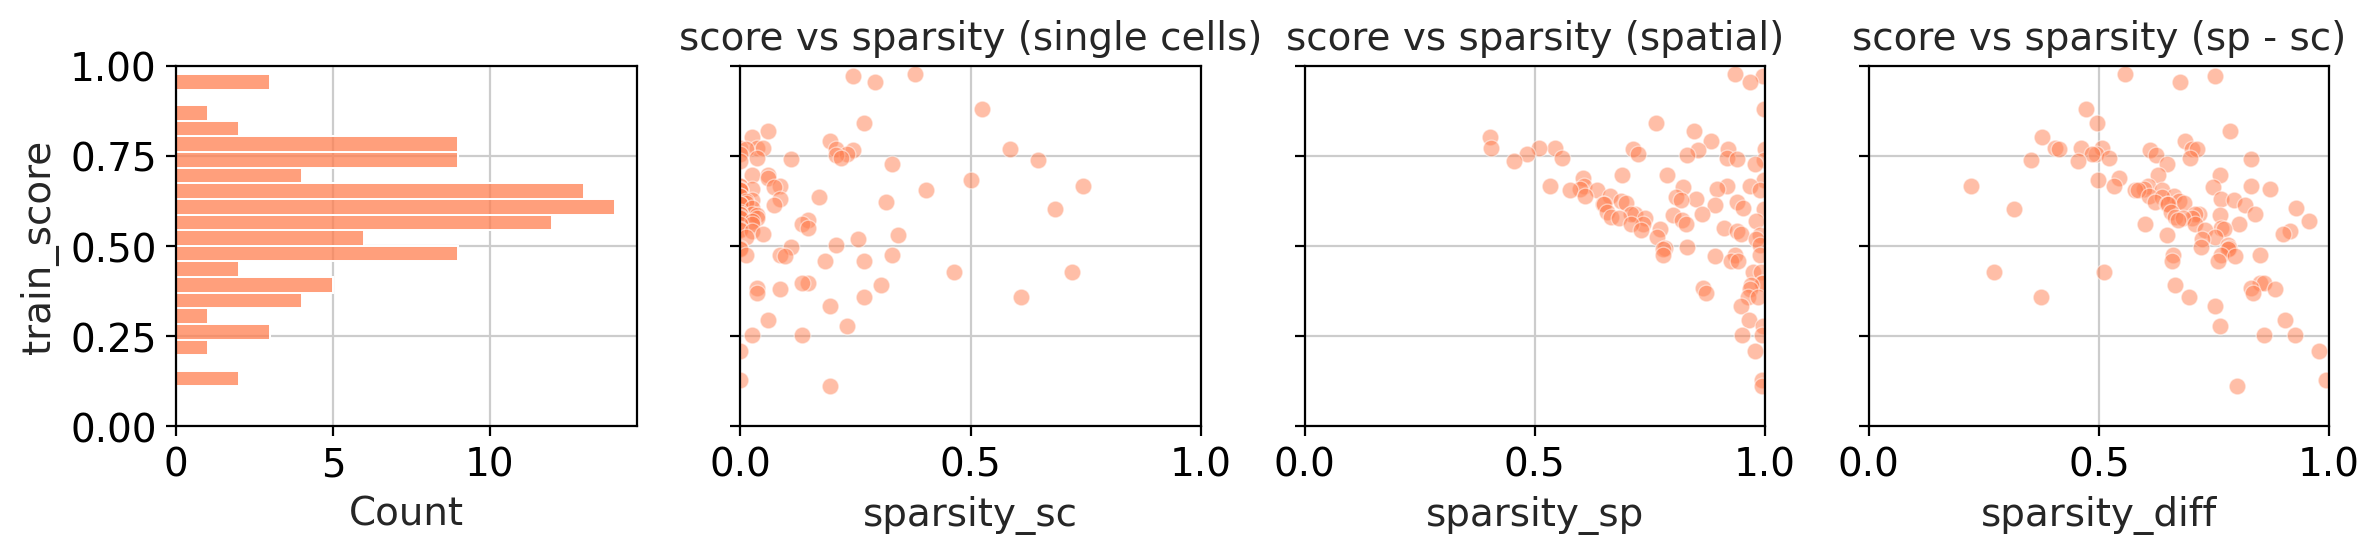

In [13]:
tg.plot_training_scores(ad_map, bins=20, alpha=.5)

In [19]:
adata_sp_new = project_genes_m(ad_map, adata_sc, cluster_label=col_cell_type,
                                   gene_to_lowercase=gene_to_lowercase)  # GEX

In [26]:
adata_sp_new.obs

cell_id  transcript_counts  control_probe_counts  \
0       aaaaibki-1                168                     0   
1       aaaaiiji-1                166                     0   
2       aaaajape-1                135                     0   
3       aaaamhbm-1                 99                     0   
4       aaabdoak-1                 61                     0   
...            ...                ...                   ...   
333819  oikcjjff-1                309                     0   
333820  oikcnngn-1                110                     0   
333821  oikcockp-1                 93                     0   
333823  oikdapol-1                 51                     0   
333824  oikdccbg-1                103                     0   

        control_codeword_counts  unassigned_codeword_counts  \
0                             0                           0   
1                             0                           0   
2                             0                           0   
3                             0                           0   
4                             0                           0   
...                         ...                         ...   
333819                        0                           0   
333820                        0                           0   
333821                        0                           0   
333823                        0                           0   
333824                        0                           0   

        deprecated_codeword_counts  total_counts   cell_area  nucleus_area  \
0                                0         168.0  328.150481     13.908126   
1                                0         166.0  107.607348     18.649532   
2                                0         135.0  110.226410     10.250469   
3                                0          99.0   46.736720     16.482032   
4                                0          61.0   22.216876      6.954063   
...                            ...           ...         ...           ...   
333819                           0         309.0  102.504691     41.092189   
333820                           0         110.0   62.947815      6.999219   
333821                           0          93.0   45.472345      9.979532   
333823                           0          51.0   33.235001     14.946719   
333824                           0         103.0   53.419846     20.952501   

              region             Sample Sample ID Patient     Status  \
0       cell_circles  Uninflamed-50452A    50452A   50452  Available   
1       cell_circles  Uninflamed-50452A    50452A   50452  Available   
2       cell_circles  Uninflamed-50452A    50452A   50452  Available   
3       cell_circles  Uninflamed-50452A    50452A   50452  Available   
4       cell_circles  Uninflamed-50452A    50452A   50452  Available   
...              ...                ...       ...     ...        ...   
333819  cell_circles  Uninflamed-50452A    50452A   50452  Available   
333820  cell_circles  Uninflamed-50452A    50452A   50452  Available   
333821  cell_circles  Uninflamed-50452A    50452A   50452  Available   
333823  cell_circles  Uninflamed-50452A    50452A   50452  Available   
333824  cell_circles  Uninflamed-50452A    50452A   50452  Available   

                Project Sample Location    Inflamed    Slide  GRID ID  \
0       scRNA & Spatial  Terminal Ileum  uninflamed  0010700  1011335   
1       scRNA & Spatial  Terminal Ileum  uninflamed  0010700  1011335   
2       scRNA & Spatial  Terminal Ileum  uninflamed  0010700  1011335   
3       scRNA & Spatial  Terminal Ileum  uninflamed  0010700  1011335   
4       scRNA & Spatial  Terminal Ileum  uninflamed  0010700  1011335   
...                 ...             ...         ...      ...      ...   
333819  scRNA & Spatial  Terminal Ileum  uninflamed  0010700  1011335   
333820  scRNA & Spatial  Terminal Ileum  uninflamed  0010700  1011335   
333821  scRNA & Spatial  Terminal Ileu

In [36]:
ad_map

AnnData object with n_obs × n_vars = 82 × 312393
    obs: 'cell_type', 'cluster_density'
    var: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_

In [25]:
adata_sp_new

AnnData object with n_obs × n_vars = 312393 × 30075
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_filter_pmt', 'cell_filter_ncounts', '

In [24]:
tg.plot_cell_annotation_sc(adata_sc, list(pd.unique(adata_sc.obs[col_cell_type])), perc=0.02)

KeyError: 'tangram_ct_pred'

In [36]:
ad_map

AnnData object with n_obs × n_vars = 82 × 312393
    obs: 'cell_type', 'cluster_density'
    var: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_

In [28]:
    df_compare = tg.compare_spatial_geneexp(
        adata_sp_new, adata_sp, adata_sc)  # comparison

In [32]:
set(adata_sp_new.var_names).difference(set(selves[0].rna.var_names))

{'RP11-860B13.3',
 'FSBP',
 'MAP3K5',
 'ZNF319',
 'NUDT19',
 'RP11-71L14.4',
 'XXyac-YR21IF11.3',
 'AC099684.1',
 'TUT7',
 'MOV10',
 'UTP25',
 'TMED2',
 'EYS',
 'SLC16A11',
 'RP11-666O2.2',
 'AC112715.2',
 'TSPAN7',
 'TOLLIP-AS1',
 'SLAMF7',
 'RP11-116D17.1',
 'SLC27A4',
 'CAB39L',
 'MAP1LC3B',
 'CLIP1-AS1',
 'AC098820.4',
 'RP11-85O21.5',
 'BFSP2',
 'LINC01170',
 'MADD',
 'RP11-286H14.4',
 'LINC02754',
 'SLC7A10',
 'SLC16A3',
 'TTC31',
 'RP11-326A13.1',
 'THOP1',
 'CTD-2619J13.9',
 'AC011294.3',
 'LINC00645',
 'RP11-795F19.5',
 'DNAI1',
 'ANKRD36',
 'CEMP1',
 'NDRG3',
 'CMKLR1',
 'QSER1',
 'TUBB2B',
 'LINC00910',
 'RP11-114M1.2',
 'LRRC4B',
 'RP11-35G9.3',
 'CACFD1',
 'RP11-52J3.2',
 'ZNF644',
 'CYP2C18',
 'PACRG',
 'GIPC1',
 'PSTPIP1',
 'MRFAP1L1',
 'RP11-419I17.2',
 'RP11-19D2.1',
 'AC083864.3',
 'ZNF571-AS1',
 'MRAP-AS1',
 'NCMAP',
 'GSDMA',
 'TMED7',
 'ANAPC5',
 'AC012360.4',
 'KASH5',
 'XKR7',
 'CLEC1B',
 'TSSC4',
 'AC097467.2',
 'ATPSCKMT',
 'RP11-258F22.1',
 'LINC01891',
 'SFTA

In [59]:
def construct_obs_plot(dfp, adata, perc=0, suffix=None):
    """Helper function from Tangram (modified)."""
    adata = adata.copy()
    adata.obs = adata.obs.drop(list(dfp.columns), axis=1, errors="ignore")
    dfp = dfp.reindex(adata.obs.index)
    dfp = dfp.clip(dfp.quantile(perc), dfp.quantile(1 - perc), axis=1)  # clip
    dfp = (dfp - dfp.min()) / (dfp.max() - dfp.min())  # normalize
    if suffix:
        dfp = dfp.add_suffix(" ({})".format(suffix))
    adata.obs = pd.concat([adata.obs, dfp], axis=1)
    return adata


In [ ]:
cr.pl.plot_integration_spatial(
                adata_sp, adata_sp_new=adata_sp_new, adata_sc=adata_sc,
                col_cell_type=[col_cell_type, "leiden"],
                ad_map=ad_map, df_compare=df_compare,
                plot_genes=["CDKN1A", "COL6A1"])

In [20]:
adata_sp

AnnData object with n_obs × n_vars = 312393 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_filter_pmt', 'cell_filter_ncounts', 'ce

In [60]:
            annots = list(pd.unique(adata_sc.obs[col_cell_type]))
            dff = adata_sp.obsm["tangram_ct_pred"][annots]
            tmp = construct_obs_plot(dff, adata_sp, perc=0.01)

In [61]:
cr.pl.plot_spatial(
                tmp, color=annots)  # cell type spatial plot

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

[<Axes: title={'center': 'germinal center B cell'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'B cell'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'gamma-delta T cell'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'memory B cell'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'regulatory T cell'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'naive B cell'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'plasma cell'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'T follicular helper cell'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'enterocyte of colon'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'activated CD4-positive, alpha-beta T cell'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'CD8-positive, alpha-beta memory T cell'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'cent

ValueError: Image size of 17600x84000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 8800x42000 with 164 Axes>

In [69]:
adata_sp.uns['spatial'][list(adata_sp.uns['spatial'].keys())[0]]['images']

{'Uninflamed-50452A___morphology_mip_scale0': ImageContainer[shape=(57808, 45580), layers=['image']],
 'Uninflamed-50452A___morphology_mip_scale1': ImageContainer[shape=(28904, 22790), layers=['image']],
 'Uninflamed-50452A___morphology_mip_scale2': ImageContainer[shape=(14452, 11395), layers=['image']],
 'Uninflamed-50452A___morphology_mip_scale3': ImageContainer[shape=(7226, 5697), layers=['image']],
 'Uninflamed-50452A___morphology_mip_scale4': ImageContainer[shape=(3613, 2848), layers=['image']],
 'Uninflamed-50452A___morphology_focus_scale0': ImageContainer[shape=(57808, 45580), layers=['image']],
 'Uninflamed-50452A___morphology_focus_scale1': ImageContainer[shape=(28904, 22790), layers=['image']],
 'Uninflamed-50452A___morphology_focus_scale2': ImageContainer[shape=(14452, 11395), layers=['image']],
 'Uninflamed-50452A___morphology_focus_scale3': ImageContainer[shape=(7226, 5697), layers=['image']],
 'Uninflamed-50452A___morphology_focus_scale4': ImageContainer[shape=(3613, 2848

In [85]:

def construct_obs_spatial_integration(dfp, adata_sp, adata_sc, col_cell_type,
                                      perc=0, suffix=None):
    """
    Helper function to normalize densities/probabilities & transfer
    cell type prediction labels from Tangram (modified).
    Also incorporates code from
    https://github.com/broadinstitute/Tangram/issues/96.
    """
    adata = adata_sp.copy()
    annots = list(pd.unique(adata_sc.obs[col_cell_type]))
    dfp = adata.obsm["tangram_ct_pred"][annots]
    adata.obs = adata.obs.drop(list(dfp.columns), axis=1, errors="ignore")
    dfp = dfp.reindex(adata.obs.index)
    dfp = dfp.clip(dfp.quantile(perc), dfp.quantile(1 - perc), axis=1)  # clip
    dfp = (dfp - dfp.min()) / (dfp.max() - dfp.min())  # normalize
    if suffix:
        dfp = dfp.add_suffix(" ({})".format(suffix))
    adata.obs = pd.concat([adata.obs, dfp], axis=1)
    preds = pd.DataFrame()
    preds[col_annotation] = adata.obsm["tangram_ct_pred"].idxmax(axis=1)
    preds["tangram_score"] = preds.apply(lambda x: max(x), axis=1)
    return adata, dfp, preds

In [97]:
    tmp, dfp, preds = construct_obs_spatial_integration(
        adata_sp_new.copy(), adata_sc.copy(), col_cell_type, perc=0.01, suffix=None)

In [98]:
    adata_sp_new.obsm["tangram"] = tmp.obs[dfp.columns]
    adata_sp_new.obs = adata_sp_new.obs.join(preds)

In [99]:
adata_sp_new.obs

cell_id  transcript_counts  control_probe_counts  \
0       aaaaibki-1                168                     0   
1       aaaaiiji-1                166                     0   
2       aaaajape-1                135                     0   
3       aaaamhbm-1                 99                     0   
4       aaabdoak-1                 61                     0   
...            ...                ...                   ...   
333819  oikcjjff-1                309                     0   
333820  oikcnngn-1                110                     0   
333821  oikcockp-1                 93                     0   
333823  oikdapol-1                 51                     0   
333824  oikdccbg-1                103                     0   

        control_codeword_counts  unassigned_codeword_counts  \
0                             0                           0   
1                             0                           0   
2                             0                           0   
3                             0                           0   
4                             0                           0   
...                         ...                         ...   
333819                        0                           0   
333820                        0                           0   
333821                        0                           0   
333823                        0                           0   
333824                        0                           0   

        deprecated_codeword_counts  total_counts   cell_area  nucleus_area  \
0                                0         168.0  328.150481     13.908126   
1                                0         166.0  107.607348     18.649532   
2                                0         135.0  110.226410     10.250469   
3                                0          99.0   46.736720     16.482032   
4                                0          61.0   22.216876      6.954063   
...                            ...           ...         ...           ...   
333819                           0         309.0  102.504691     41.092189   
333820                           0         110.0   62.947815      6.999219   
333821                           0          93.0   45.472345      9.979532   
333823                           0          51.0   33.235001     14.946719   
333824                           0         103.0   53.419846     20.952501   

              region             Sample Sample ID Patient     Status  \
0       cell_circles  Uninflamed-50452A    50452A   50452  Available   
1       cell_circles  Uninflamed-50452A    50452A   50452  Available   
2       cell_circles  Uninflamed-50452A    50452A   50452  Available   
3       cell_circles  Uninflamed-50452A    50452A   50452  Available   
4       cell_circles  Uninflamed-50452A    50452A   50452  Available   
...              ...                ...       ...     ...        ...   
333819  cell_circles  Uninflamed-50452A    50452A   50452  Available   
333820  cell_circles  Uninflamed-50452A    50452A   50452  Available   
333821  cell_circles  Uninflamed-50452A    50452A   50452  Available   
333823  cell_circles  Uninflamed-50452A    50452A   50452  Available   
333824  cell_circles  Uninflamed-50452A    50452A   50452  Available   

                Project Sample Location    Inflamed    Slide  GRID ID  \
0       scRNA & Spatial  Terminal Ileum  uninflamed  0010700  1011335   
1       scRNA & Spatial  Terminal Ileum  uninflamed  0010700  1011335   
2       scRNA & Spatial  Terminal Ileum  uninflamed  0010700  1011335   
3       scRNA & Spatial  Terminal Ileum  uninflamed  0010700  1011335   
4       scRNA & Spatial  Terminal Ileum  uninflamed  0010700  1011335   
...                 ...             ...         ...      ...      ...   
333819  scRNA & Spatial  Terminal Ileum  uninflamed  0010700  1011335   
333820  scRNA & Spatial  Terminal Ileum  uninflamed  0010700  1011335   
333821  scRNA & Spatial  Terminal Ileu

[autoreload of corescpy.processing.spatial_pp failed: Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/elizabeth/elizabeth/coresc

<Axes: title={'center': 'tangram_prediction'}, xlabel='spatial1', ylabel='spatial2'>

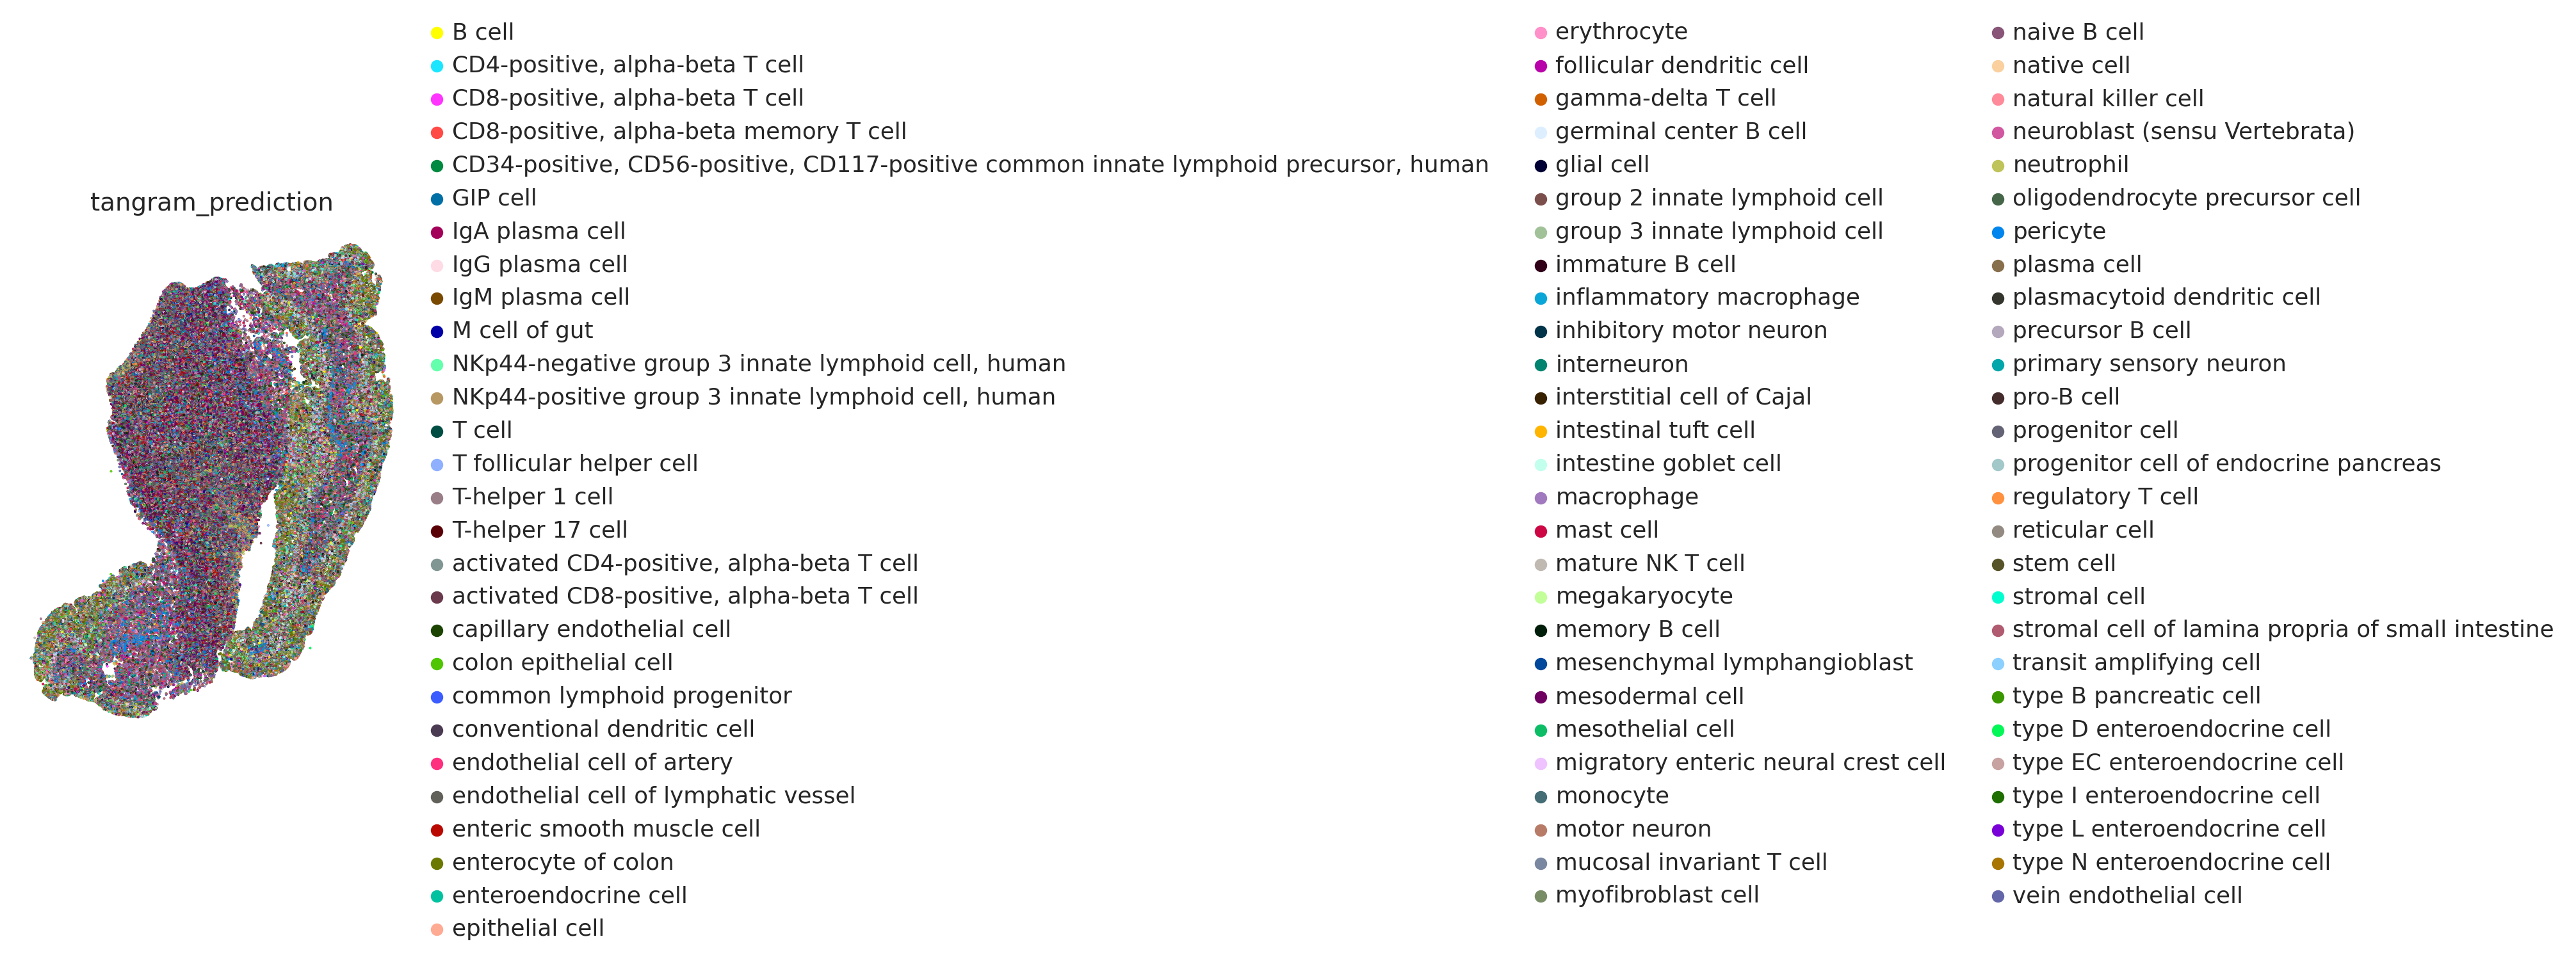

In [101]:
cr.pl.plot_spatial(adata_sp_new, color="tangram_prediction")

In [81]:
adata_sp_new

AnnData object with n_obs × n_vars = 312393 × 30075
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_filter_pmt', 'cell_filter_ncounts', '

stromal cell  mesodermal cell  enterocyte of colon  \
0       4.116921e-06     2.160545e-07         1.560205e-07   
1       4.668709e-06     3.198976e-06         5.327206e-06   
2       4.307278e-06     1.183731e-05         1.186337e-07   
3       1.657194e-05     3.928413e-07         4.530387e-08   
4       4.222053e-06     1.309410e-06         3.036670e-07   
...              ...              ...                  ...   
333819  4.077615e-07     3.395266e-07         2.053164e-05   
333820  7.353095e-06     3.437912e-06         5.424317e-07   
333821  3.140802e-06     2.528930e-06         5.013658e-07   
333823  3.920977e-06     9.895002e-07         5.418763e-07   
333824  9.021578e-08     2.401700e-07         6.752302e-08   

        enteric smooth muscle cell  progenitor cell    glial cell  \
0                     7.312141e-07     1.482248e-07  1.521942e-06   
1                     6.648618e-07     4.152688e-07  2.657698e-06   
2                     4.543995e-07     3.303813e-07  1.727640e-07   
3                     2.072436e-06     1.709123e-07  1.941059e-07   
4                     2.839008e-07     1.765195e-07  1.036513e-05   
...                            ...              ...           ...   
333819                2.772538e-07     1.019153e-06  2.528620e-07   
333820                1.469758e-05     1.174044e-06  1.025892e-06   
333821                2.689860e-07     9.025425e-06  4.145470e-07   
333823                3.952201e-06     6.132507e-06  4.080313e-07   
333824                1.961437e-07     1.490977e-07  7.137278e-07   

        transit amplifying cell     stem cell      pericyte  naive B cell  \
0                  8.968514e-08  1.290307e-07  9.375512e-08  1.192105e-06   
1                  1.003431e-06  1.877937e-07  4.275875e-07  2.019948e-07   
2                  7.055369e-08  1.724033e-07  1.779538e-07  1.142912e-07   
3                  3.198402e-08  7.017840e-07  6.810157e-08  8.294860e-07   
4                  1.155522e-07  3.051537e-07  2.617592e-07  1.284395e-07   
...                         ...           ...           ...           ...   
333819             1.519234e-07  9.209793e-07  1.120718e-07  1.084176e-06   
333820             4.671696e-08  7.199778e-07  3.788871e-07  1.386050e-07   
333821             3.795413e-07  3.569823e-05  3.550614e-07  9.859773e-07   
333823             1.038695e-07  1.383299e-07  8.719965e-08  2.173060e-06   
333824             6.540884e-08  1.608728e-07  5.483093e-08  3.865080e-05   

        myofibroblast cell  intestine goblet cell  capillary endothelial cell  \
0             4.406199e-07           1.292426e-07                1.168952e-07   
1             5.430567e-07           7.822237e-07                1.458159e-07   
2             1.240945e-06           1.428969e-07                6.278363e-06   
3             2.526090e-07           1.017384e-07                3.055677e-07   
4             3.326737e-07           6.199831e-08                2.753085e-07   
...                    ...                    ...                         ...   
333819        1.643352e-07           1.357588e-06                1.708664e-07   
333820        1.267585e-06           1.931498e-07                1.916969e-07   
333821        4.078611e-06           7.172187e-07                2.697454e-07   
333823        2.282692e-06           1.119875e-07                2.397526e-07   
333824        5.047627e-07           1.911151e-07                1.055689e-07   

        activated CD8-positive, alpha-beta T cell  IgA plasma cell  \
0                                    4.219129e-06     5.624624e-07   
1                                    1.969118e-05     5.444977e-07   
2                                    1.075658e-07     1.820503e-07   
3                                    1.314267e-07     2.244788e-07   
4                                    1.449965e-05     1.512691e-07   
...                                           ...              ...   
333819                               3.113259e

In [75]:
tg.plot_cell_annotation(adata_sp_new, annots, x='x', y='y')

KeyError: 'cell_type'

In [63]:
tg.utils.count_cell_annotations(ad_map, adata_sc, adata_sp_new,
                                annotation=col_cell_type, threshold=0.5)

ValueError: Missing parameter for tangram deconvolution. Run `sqidpy.im.calculate_image_features`.

In [62]:
tg.utils.deconvolve_cell_annotations(adata_sp_new, filter_cell_annotation=None)

[autoreload of corescpy.visualization failed: Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/elizabeth/elizabeth/corescpy/corescpy/visualization/__init__.py", line 13, in <module>
    from .spatial_plots import (plot_tiff, plot_spatial,
ImportError: cannot import name 'constr

ValueError: Missing tangram parameters. Run `count_cell_annotations`.

In [26]:
ad_map

AnnData object with n_obs × n_vars = 82 × 312393
    obs: 'cell_type', 'cluster_density'
    var: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_

In [ ]:
key_cell_type, col_ann = None, "leiden_sub"
for s in selves:
    s.plot_spatial(color=col_ann)

In [ ]:
s.annotate_clusters(file_ann, col_cell_type="leiden", col_annotation="Annotation")
s.annotate_clusters(file_ann, col_cell_type="leiden_subcluster", col_annotation="Annotation_Subcluster")
s.plot_spatial(color="Annotation_Subcluster")

In [ ]:
dff = pd.concat([pd.Series(marker_genes_dict[x]).to_frame("Marker")
                 for x in marker_genes_dict], keys=marker_genes_dict)
dff[dff.Marker.isin(self.rna.var_names)]

In [ ]:
adf = pd.read_excel(file_ann)
adf


i = 0
self = selves[i]
self.add_image(paths_he[i], name="H_E", file_align=paths_he_align[i])